# Visualize Graph Data Model Using Diagram-as-Code: RDF

This notebook shows how to introspect Resource Description Framework (RDF) data in your Neptune database and draw a diagram representing the contents of that model. It uses a diagram-as-code approach. We use SPARQL queries to discover your graph schema. We then use PlantUML to draw the schema.

What we try to draw:
- A set of classes with properties representing the structure of instances in the database.
- Edge properties using reification, named graphs, nary relations.
- Aspects of the ontology, including classes, properties, and restrictions. 

What we do not draw (yet):
- SHACL

### Min Requirement: 
- Neptune 1.2.x or higher

There is a companion notebook for Labeled Property Graph.


## Setup PlantUML
We will use Plant UML to render the diagram

In [ ]:
%pip install iplantuml

** Restart kernel **

In [ ]:
import iplantuml

## Setup Discovery
Get connection to Neptune

In [ ]:
import json
import os
import rdf_discovery

def get_neptune_env(var):
    return os.popen(f"source ~/.bashrc ; echo ${var}").read().split("\n")[0]
    
# Grab Neptune cluster host/port from notebook instance environment variables
GRAPH_NOTEBOOK_HOST= get_neptune_env("GRAPH_NOTEBOOK_HOST")
GRAPH_NOTEBOOK_PORT= get_neptune_env("GRAPH_NOTEBOOK_PORT")
GRAPH_NOTEBOOK_AUTH_MODE= get_neptune_env("GRAPH_NOTEBOOK_AUTH_MODE")
AWS_REGION= get_neptune_env("AWS_REGION")
USE_IAM_AUTH = GRAPH_NOTEBOOK_AUTH_MODE != 'DEFAULT'

rdf_discovery.set_neptune_env(GRAPH_NOTEBOOK_HOST, GRAPH_NOTEBOOK_PORT, AWS_REGION, USE_IAM_AUTH)


## Load some data if you like
If not, skip and we'll go with what you've got

### Air routes data

In [ ]:
%seed --model rdf --dataset airports

### Edge properties data

In [ ]:
%%sparql

# Named graphs - http://kelvinlawrence.net/air-routes/class/Airport route predicate has this

PREFIX : <http://example.org/test/>

INSERT DATA {
    # reification
    :mike a :ReMan .
    :joe a :ReMan .
    :lulu a :ReWoman .
    :freckles a :ReWoman .
    
    :ml_marriage a rdf:Statement .
    :ml_marriage rdf:subject :mike .
    :ml_marriage rdf:predicate :hasSpouse .
    :ml_marriage rdf:object :lulu .
    :ml_marriage :rating 6 .
    :ml_marriage :ratingSource :BetterMarriages .
    
    :jf_marriage a rdf:Statement .
    :jf_marriage rdf:subject :joe .
    :jf_marriage rdf:predicate :hasSpouse .
    :jf_marriage rdf:object :freckles .
    :jf_marriage :rating 9 .
    :jf_marriage :ratingSource :DearlyBetrothed .
    
    # singleton
    :luke a :SMan .
    :mark a :SMan .
    :veronica a :SWoman .
    :seema a :SWoman .
    
    :luke :hasSpouse_1 :veronica .
    :hasSpouse_1 rdf:singletonPropertyOf :hasSpouseSingleton .
    :hasSpouse_1 :rating 7 .
    :hasSpouse_1 :ratingSource :DearlyBetrothed .

    :mark :hasSpouse_2 :seema .
    :hasSpouse_2 rdf:singletonPropertyOf :hasSpouseSingleton .
    :hasSpouse_2 :rating 9 .
    :hasSpouse_2 :ratingSource :WeddingsPartiesAnything .

    # n-ary
    :jojo a :NMan .
    :mardi a :NWoman .
    _:b0 a :NMarriage .
    _:b0 :partner :jojo .
    _:b0 :partner :mardi .
    _:b0 :rating 9 .
    _:b0 :ratingSource :VegasChapels .
}

### Lists, multival, multitype props

In [ ]:
%%sparql

PREFIX : <http://example.org/test/>

INSERT DATA {
    :mobj1 a :Multitude .
    
    :mobj1_x a :Multitude2 .
    :mobj1_y a :Multitude2 .
    :mobj1_z a :Multitude3 .
    
    # data
    
    # single val
    :mobj1 :md1 "val" .
 
     # multi val
    :mobj1 :md2 "val" .
    :mobj1 :md2 "val2" .

     # multi val and type
    :mobj1 :md3 "val" .
    :mobj1 :md3 "val2" .
    :mobj1 :md3 42 .

     # mixed obj/data
    :mobj1 :md4 "val" .
    :mobj1 :md4 :mobj1_x .

    # object
    
    # single val
    :mobj1 :mo1 :mobj1_x .
 
     # multi val
    :mobj1 :mo2 :mobj1_x .
    :mobj1 :mo2 :mobj1_y .

     # multi val and type
    :mobj1 :mo3 :mobj1_x .
    :mobj1 :mo3 :mobj1_y .
    :mobj1 :mo3 :mobj1_z .

    # list
    
    :mobj1 :mdl1 ( "val" ) .
    :mobj1 :mdl2 ( "val" "val2" ) .
    :mobj1 :mdl3 ( "val" "val2" 42 ) .
    :mobj1 :mdl4 ( "val" :mobj1_x ) .
    :mobj1 :mol1 ( :mobj1_x ) .
    :mobj1 :mol2 ( :mobj1_x :mobj1_y ) .
    :mobj1 :mol3 ( :mobj1_x :mobj1_y :mobj1_z ) .
    
    # bag (Seq, Alt, Container would be much the same)
    
    :mobj1 :mdc1 [
        a rdf:Bag ;
        rdf:_1 "val" 
      ] .
    :mobj1 :mdc2 [
        a rdf:Bag ;
        rdf:_1 "val" ;
        rdf:_2 "val2" 
      ] .
      
    :mobj1 :mdc3 [
        a rdf:Bag ;
        rdf:_1 "val" ;
        rdf:_2 "val2" ;
        rdf:_3 :mobj1_x
      ] .

    :mobj1 :mdc4 [
        a rdf:Bag ;
        rdf:_1 "val" ;
        rdf:_2 :mobj1_x
      ] .

    :mobj1 :moc1 [
        a rdf:Bag ;
        rdf:_1 :mobj1_x
      ] .

    :mobj1 :moc2 [
        a rdf:Bag ;
        rdf:_1 :mobj1_x ;
        rdf:_2 :mobj1_y 
      ] .

    :mobj1 :moc3 [
        a rdf:Bag ;
        rdf:_1 :mobj1_x ;
        rdf:_2 :mobj1_y ;
        rdf:_3 :mobj1_z
      ] .}

### Same class name, different namespace

In [ ]:
%%sparql

# Class under different 

PREFIX : <http://example.org/test2/>

INSERT DATA {
    :mobj1 a :Multitude .
    :mobj1 rdfs:label "different test!" .
}


### Lots of reification and singleton instances

In [ ]:
for i in range(1000):
    singpreds = ""
    for j in range(50):
        singpreds += f'''
    :mork{i} :testpred_{j} {j} .
    :testpred_{j} rdf:singletonPropertyOf :testPredSingleton .
    :testpred_{j} :measure {j} .
    :testpred_{j} :measure {j + 1} .
'''

    q = f'''
PREFIX : <http://example.org/test/>

INSERT DATA {{
    # reification
    :mike{i} a :ReifMan .
    :reif{i} a rdf:Statement .
    :reif{i} rdf:subject :mike{i} .
    :reif{i} rdf:predicate :testpred .
    :reif{i} rdf:object ( {i} {i+1} {i+2} ) .
    :reif{i} :measure :reif{i} .
        
    # singleton
    :mork{i} a :SingMan .
    :mork{i} :justAList ( {i} {i+1} {i+2} ) .
    :mork{i} :justABag [
        a rdf:Bag ;
        rdf:_1 {i} ;
        rdf:_2 {i + 1}
      ] .
    {singpreds}

}}    
'''
    if i % 20 == 0:
        print(i)
    rdf_discovery.execute_sparql(q, "update")


### Ontology

For fun, also try loading data used in https://github.com/aws-samples/amazon-neptune-ontology-example-blog/blob/main/notebook/Neptune_Ontology_Example.ipynb.

Follow the import steps there. 

### Movies

In [ ]:
# Use the boto3 session SDK to fetch the region being used for this workshop
import boto3

# Dynamically build the S3 path based on the region
s3datapath = "s3://ee-assets-prod-" + AWS_REGION + \
    "/modules/f3f89ef4607743429fb01ae23d983197/v1/workshop/data-v2/imdb-rdf"

# Using the Neptune Workbench's %load magic to instantiate a bulk load from the social graph in S3
%load -s {s3datapath} -f nquads -p OVERSUBSCRIBE --store-to result1 --run

In [ ]:
%load_status {result1['payload']['loadId']} --details --errors

## Discover what's in the Neptune database.

Find a schema from RDF instances, plus ontology. 

We don't use the summary API for this. Rather, we run SPARQL queries to sample the data. 



In [ ]:
observed = rdf_discovery.discover_observational()
print(json.dumps(observed, indent=2))


## Observe ontology too, and merge that with observed

In [ ]:
all_classes = rdf_discovery.discover_and_merge_ontological(observed)
print(json.dumps(all_classes, indent=2))


## Build PlantUML spec
Map the observed to UML class diagram PlantUML form.

In [ ]:
rdf_discovery.load_prefixes()
# ... If I needed to, I could add my own prefixes. I won't
# px = rdf_discovery.get_prefixes_by_prefix()
# rdf_discovery.add_prefix("mypfx", "http://example.org/example42/")

plantspec = rdf_discovery.to_plant_uml(all_classes)
print(plantspec)

## Render from the Spec

In [ ]:
import iplantuml
ipython = get_ipython()
ipython.run_cell_magic("plantuml", "-n rdf_all", plantspec)

## Too much? Wittle it down

Just airport

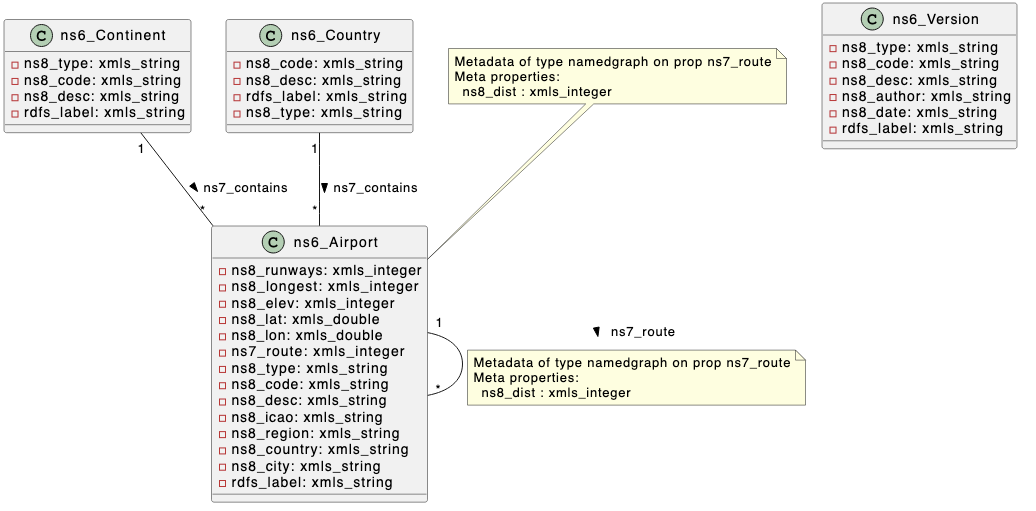

In [ ]:
AIRPORT_NS='http://kelvinlawrence.net/air-routes/class/'
class_filter = [f"{AIRPORT_NS}Continent", f"{AIRPORT_NS}Country", f"{AIRPORT_NS}Airport", f"{AIRPORT_NS}Version"]
plantspec = rdf_discovery.to_plant_uml(all_classes, class_filter)
print(plantspec)

In [ ]:
ipython = get_ipython()
ipython.run_cell_magic("plantuml", "-n rdf_airport", plantspec)